<a href="https://colab.research.google.com/github/al-alamin/ENSF619.2_ImageAnalysis/blob/main/Assignment_1/ENSF619_Assignment_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment #01

This assignment is composed of 4 tasks that your teams is supposed to propose a solution to these tasks that uses the max-tree. The deliverable for this assignment is:

1. This jupyter-notebook completed with your solution.
>- Create a GitHub repository and create a folder assignment-01. Put the jupyter-notebook with your solution in this repository and send the instructor the link. The same repository that your team created will be used for submitting the other assignments and your team final project.

You are being assessed based on:
1. Code execution - 20%
2. Clarity of the code (e.g., easy to follow, has pertinent comments, etc.) - 20%
3. Proper usage of the techniques seen in class - 40%
4. Quality of the results - 20%

More details about the assessment are available in the rubric document in the class GitHub repository.



## Setup

#### Cloning siamxt tool and the assignment repo

In [24]:
! git clone https://github.com/rmsouza01/ENSF619.2.git
! git clone https://github.com/rmsouza01/siamxt.git; cd siamxt; python setup.py install

fatal: destination path 'ENSF619.2' already exists and is not an empty directory.
fatal: destination path 'siamxt' already exists and is not an empty directory.
running install
running build
running build_py
running build_ext
running install_lib
running install_egg_info
Removing /usr/local/lib/python3.7/dist-packages/siamxt-1.0.0.egg-info
Writing /usr/local/lib/python3.7/dist-packages/siamxt-1.0.0.egg-info


#### Importing necessary libaries

In [25]:
import numpy as np # numpy is the major library in which siamxt was built upon
                   # we like the array programming style =)

# We are using PIL to read images     
from PIL import Image

# and matplotlib to display images
import matplotlib.pyplot as plt

import siamxt  

### Some Helper methods

Here, we have defined some helper methods that are frequently used throughout the whole assignment for showing, negating, and filtering an image.

In [26]:
# takes an image as input and displays it with given title
def show_image(img, title):
    fig = plt.figure()
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(title, y=-0.1, loc='left')
    plt.show()
    print() # for some gap after each image


# returns the matrix for applying connectivity-4 
def get_four_connectivity():
    Bc = np.zeros((3,3), dtype = bool)
    Bc[1,:] = True
    Bc[:,1] = True
    return Bc


# returns the matrix for applying connectivity-8
def get_eight_connectivity():
    Bc = np.ones((3,3), dtype = bool)
    return Bc

# Input is an image and returns its negative
def get_negative_img(img):
  # Negating the image
  img_max = img.max()
  img_neg = img_max-img
  return img_neg


# Input is an image and returns a (filtered) image after applying area open filter based on the given connectivity rule (Bc) and area. 
# Every compononent smaller than the given area will be filtered out.
def apply_area_open_filter(img, Bc, area):
  #Building the max-tree of the negated image, i.e. min-tree
  mxt = siamxt.MaxTreeAlpha(img,Bc)
  #Applying an area-open filter
  mxt.areaOpen(area)
  #Recovering the image 
  img_filtered =  mxt.getImage()
  return img_filtered


# Input is an image and returns an image after applying extinction filter based on the given connectivity rule (Bc) and number of extrema (n)
# Only top n extrema will be kept
def apply_extinction_filter(img, Bc, n):   
    #Building the max-tree of the negated image, i.e. min-tree
    mxt = siamxt.MaxTreeAlpha(img, Bc)
    # Select the area attribute of the max-tree nodes from NA
    area = mxt.node_array[3,:]
    # Computes the area extinction values
    area_ext = mxt.computeExtinctionValues(area, "area")
    
    # Applies the  area extinction filter
    mxt.extinctionFilter(area_ext, n)
    #Recovering the image 
    img_filtered =  mxt.getImage()
    return img_filtered


# Input is an image and returns an image after applying bounding box filter based on the given criteria such as Wmin, Hmin, Wmax, Hmax, rr_min, rr_max
# Only the nodes that follow the given criteria will be kept
def apply_bounding_box_filter(img, Wmin, Hmin, Wmax, Hmax, rr_min, rr_max):
    # Building the max-tree of the negated image, i.e. min-tree
    mxt = siamxt.MaxTreeAlpha(img, get_eight_connectivity())
    # Bounding box-lengths
    dx = mxt.node_array[7,:] - mxt.node_array[6,:]
    dy = mxt.node_array[10,:] - mxt.node_array[9,:]
    # Rectangularity ratio
    RR = mxt.computeRR()
    # Node selection criteria
    nodes = (dx>Hmin) & (dx<Hmax) & (dy > Wmin) & (dy < Wmax) & (RR > rr_min) & (RR < rr_max)
    #Filtering the max-tree
    mxt.contractDR(nodes)
    # Recovering the filtered the image
    img_filtered = mxt.getImage()
    return img_filtered


# A different version of bounding box filter used only for fine-tuning task-2 (i.e. carotid arteries wall segmentation)
# Works as the original bounding box filter
def apply_bounding_box_filter2(img, Wmin, Hmin, Wmax, Hmax, rr_min, rr_max):
    # Building the max-tree of the negated image, i.e. min-tree
    mxt = siamxt.MaxTreeAlpha(img, get_eight_connectivity())

    # Bounding box-lengths
    dx = mxt.node_array[7,:] - mxt.node_array[6,:]
    dy = mxt.node_array[10,:] - mxt.node_array[9,:]
    # Rectangularity ratio
    RR = mxt.computeRR()
    # Node selection criteria
    nodes = (dx>Hmin) & (dx<Hmax) & (dy > Wmin) & (dy < Wmax) & (RR > rr_min) & (RR < rr_max)

    print("Nodes that have passed the bounding box filter:")
    print("-----------------------------------------------")

    for i in range(len(nodes)):
      if nodes[i] > 0:
        print(i)
    
    print("") # just for a gap in the console

    noise_index_list = [2612, 2734,3576,3608] #list of extra nodes determined by trial and error 

    # setting the extra nodes off
    for noise_index in noise_index_list:
      nodes[noise_index] = 0

    #Filtering the max-tree
    mxt.contractDR(nodes)
    # Recovering the filtered the image
    img_filtered = mxt.getImage()
    return img_filtered

## Assignment Taks

***Summary.***
 There is a total of 4 tasks in this assignment. We used different kinds of methods and filters for approaching different tasks. We modified the filters and their settings accordingly, and conducted some comparative study among different approaches. We used necessary empirical observation and fine-tuning to improve the quality of the outputs. We also discussed the possible limitations of the applied method while appropriate.

### Part 1 (Mona Lisa)

**Part 1 - Question** 

Using the max tree area signature analysis, determined CCs in the max tree
that separate Mona Lisa’s face from the background

**Part 1 - Solution** 

> ***Steps***
>> 1. We first conduct signature analysis on the given image using max-tree based on the hand-picked regional maxima.
>> 2. We determined the gradient signature from that.
>> 3. We plotted both the signature analysis (Figure 1b) and gradient (Figure 1c) on different graph for investigation.
>> 4. We observed that there is a large great reduction in the area (in signature analysis), thus a large gradient (in the gradient signature) starting at the gray-level of ~70. This indicates that a large partition might occur in this point i.e. a large component might divide into small components. Hence, these kind of point might be of our interest as potential separation point of Mona Lisa's face in the picture. 
>> 5. Therefore, we took the peak of the gradient and reconstruct both the large and small areas corresponding to this peak (see Figure 1d and 1e).
>> 6. Thus we found the point where the desired partition took place and succeeded to determine CCs in the max-tree that separate Mona Lisa’s face from the background.


> ***Implementation and Output***
>> Codes and outputs are as follows.









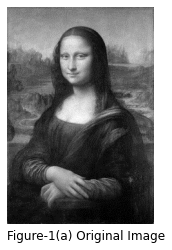

Text(0.0, -0.1, '1(e) Reconstruction at h = 85')

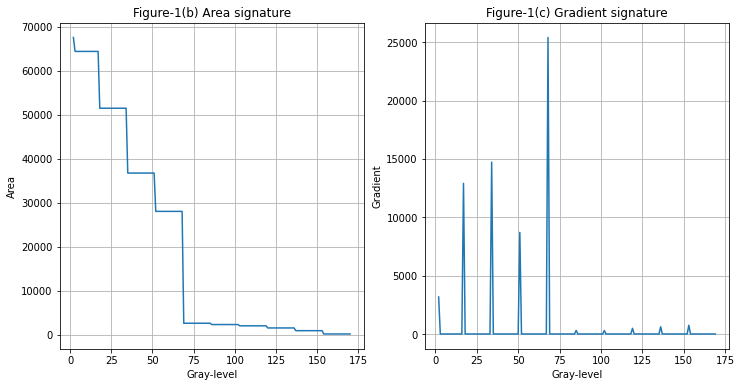

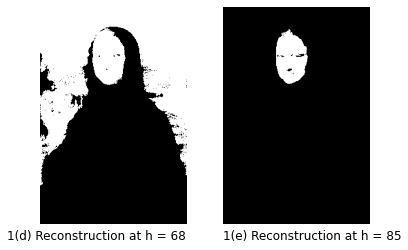

In [27]:
# Loading the image.
# Make sure the image you read is either uint8 or uint16
img = np.asarray(Image.open("/content/ENSF619.2/Assignment01/Images/monalisa.png").convert("L"))
#print(img.shape)

#Displaying the original image
show_image(img, "Figure-1(a) Original Image")



#Structuring element with connectivity-4 
Bc = get_four_connectivity()

# Building the max-tree
mxt = siamxt.MaxTreeAlpha(img,Bc)

#Hand-picked regional maxima
x,y = 83, 90

# Node corresponding to a regional maximum
node = mxt.node_index[x, y]

# Extracting area attribute from NA
area = mxt.node_array[3,:]

# Area signature computation
levels,signature =  mxt.getSignature(area, node)

#Gradient of the area signature
gradient = signature[0:-1] - signature[1:]

# Display area signature
fig = plt.figure(figsize = (12,6))
plt.subplot(121)
plt.plot(levels,signature)
plt.grid()
plt.xlabel("Gray-level")
plt.ylabel("Area")
plt.title("Figure-1(b) Area signature")


# Display gradient of the area signature
plt.subplot(122)
plt.grid()
plt.plot(levels[0:-1],gradient)
plt.xlabel("Gray-level")
plt.ylabel("Gradient")
plt.title("Figure-1(c) Gradient signature")


# Selecting the peak of the gradient
index = np.argsort(gradient)[::-1][0]

#reconstructing the node corresponding to the peak (largest area)
area1 = signature[index]
node1 = np.where(mxt.node_array[3,:] == area1)[0][0]
cc1 = mxt.recConnectedComponent(node1)

#reconstructing the node corresponding to the peak (smaller area)
area2 = signature[index + 1]
node2 = np.where(mxt.node_array[3,:] == area2)[0][0]
cc2 = mxt.recConnectedComponent(node2)


#Displaying the nodes reconstructed    
fig = plt.figure()
plt.subplot(121)
plt.imshow(cc1, cmap='Greys_r')
plt.axis('off')
plt.title("1(d) Reconstruction at h = %d" %mxt.node_array[2,node1],y=-0.1, loc='right')
plt.subplot(122)
plt.imshow(cc2, cmap='Greys_r')
plt.axis('off')
plt.title("1(e) Reconstruction at h = %d" %mxt.node_array[2,node2],y=-0.1, loc='left')

### Part 2 artery

**Part 2 - Question**

Apply a series of filters to this image to segment the carotid arteries wall

**Part 2 - Solution**


> ***Steps***

>> 1. Since we want to segment the arteries wall only, we decided to apply bounding box filter here.
>> 2. We defined the bounding box filter with 6 parameters (i.e. Wmin, Hmin, Wmax, Hmax, rr_min, rr_max) instead of 5 (i.e. Wmin, Hmin, Wmax, Hmax, rr). We wanted to allow a range of rr for our implementation using rr_min and rr_max.   
>> 3. We chose the appropriate values of the bounding box parameters (i.e. Wmin, Hmin, Wmax, Hmax, rr_min, rr_max) based on our empirical observation of the image-parts to be segmented (e.g. dimension of the arteries wall) and some further fine-tuning based on the observation of the outputs.
>> 4. However, it was difficult to segment only the arteries wall removing all other components using this bounding box filter. For example, two extra little components were still showing up below the arteries wall with above-mentioned setting (see Figure 2b).  
>> 5. We then decided to examine the node array prepared in the bounding box function with same setting. We checked and printed the nodes that have passed our filter which are 2612, 2734, 3576, 3608, 3691, 3706, 4066. Hence, each component of our current ouput (Figure 2b) corresponds to any of these nodes. We then found out the node numbers of the extra components by using different combination (trial and error) and excluded them from the output by manually setting them off. We have written a new function (named *apply_bounding_box_filter2*) for this purpose. 
>> 6. Thus we succeeded to segment the arteries walls only (see Figure 2c).

> ***Limitation***
>> The modification we did here to improve the output (Figure 2c) is based on image-specific empirical study and fine-tuning. Hence, this exact solution (i.e. node numbers) would not be applicable to different images. However, similar approach (of fine-tuning) could be employed to solve other problems. 

> ***Implementation and Output***
>> Codes and outputs are as follows.






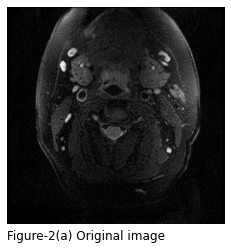

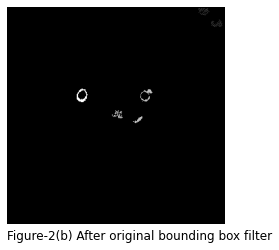


Nodes that have passed the bounding box filter:
-----------------------------------------------
2612
2734
3576
3608
3691
3706
4066



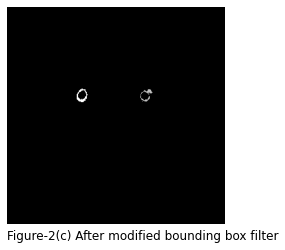

In [28]:
# Loading the image.
# Make sure the image you read is either uint8 or uint16
img = np.asarray(Image.open("/content/ENSF619.2/Assignment01/Images/carotid.png").convert("L"))

# Showing original image
show_image(img, "Figure-2(a) Original image")


# Setting up parameters for bounding box filter
Wmin = 12.99  # Minimum bounding-box width
Hmin = 6.95 # Minimum bounding-box height
Wmax = 17.5 # Maximum bounding-box width
Hmax = 19.5 # Maximum bounding-box height
rr_min = 0.30 # Minimum rectangularity ratio
rr_max = 0.38


# Applying the original bounding box filter
img_filtered1 = apply_bounding_box_filter(img, Wmin, Hmin, Wmax, Hmax, rr_min, rr_max)
show_image(img_filtered1, "Figure-2(b) After original bounding box filter")


# Applying the modified bounding box filter 
img_filtered2 = apply_bounding_box_filter2(img, Wmin, Hmin, Wmax, Hmax, rr_min, rr_max)
show_image(img_filtered2, "Figure-2(c) After modified bounding box filter")

### Part 3 (filter white spots)

**Part 3 - Question** 

Apply a series of filters to remove the white artifacts in the image

**Part 3 - Solution** 



> ***Steps***
1. We used Area Open filter for filtering out the spots using an appropriate area threshold.
2. Since the spots are white, we did not have to use min-tree.
3. We built the max-tree and applied area filter on that.
4. We experimented with different values of area and picked the one (area=50) that gives the best output (Figure 3b).

> ***Implementation and Output***
>> Codes and outputs are as follows.



Text(0.0, -0.1, 'Figure-3(b) area-open, area=50 ')

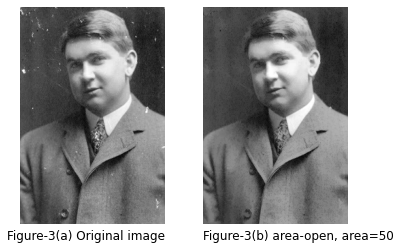

In [29]:
# Loading the image.
# Make sure the image you read is either uint8 or uint16
img = np.asarray(Image.open("/content/ENSF619.2/Assignment01/Images/filtering-image.jpg").convert("L"))
#print(img.shape)


#Structuring element with connectivity-8
Bc = get_eight_connectivity()

# Area threshold
area = 50

#applying area filter
img_filtered = apply_area_open_filter(img, Bc, area)


#Displaying the orignal and filtered image
fig = plt.figure()

plt.subplot(1,2,1)
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title("Figure-3(a) Original image", y=-0.1, loc="right")

plt.subplot(1,2,2)
plt.imshow(img_filtered, cmap='gray')
plt.axis('off')
plt.title("Figure-3(b) area-open, area=%d " %area, y=-0.1, loc="left")

### Part 4 (Remove Objects)

**Part 4 - Question** 

Apply a series of filters that will remove all objects in the image except for the two pens

**Part 4 - Solution** 

> ***Steps***
>> **Approach-1 (using Extinction and Area Filter)**
>> 1. We first experimented with different types of filters. Experimenting with the extinction filter, we found that the pens exist in the top 6 extrema where the left pen comes 6th. Hence, by using extinction at n=6, we were able to remove all the objects except 6 extrema i.e. two pens and four other components (see Figure 4a).
>> 2. We then experimented with area open filter and were able to remove all the objects except two pens and two other objects at area=3000 (see Figure 4b).
>> 3. We observed that these two extra objects of area open filters are different from the four extra objects of extinction filters. Hence, these filters can complement each other for our task.
>> 4. Therefore, we applied these two filters combinedly on the image and found an output where only two pen remain (see Figure 4e).

>> **Approach-2 (using Bounding Box Filter)**
>> 1. Though we were able to remove the extra objects with approach-1, there were still some light marks of the removed objects in that. Then we experimented with bounding box filter.
>> 2. We chose the appropriate values of the bounding box parameters (i.e. Wmin, Hmin, Wmax, Hmax, rr_min, rr_max) based on our observation of pen dimension and size.
>> 3. We were able to produce a clear image of only two pens removing all other objects in this way (see Figure 4f).


> ***Limitation***

>>Aprroach-1 will not work for all images. This only worked because top 6 maxima points contains the 4 objects with two pen. Open area filter can remove the other two objects because the area of other two object is less than 3000. So, if these objects were larger or the pen's orientation were differnt this we would have to take different approach.

> ***Implementation and Output***
>> Codes and outputs are as follows.


##### Loading the Image

In [30]:
# Loading the image.
# Make sure the image you read is either uint8 or uint16
img_org = np.asarray(Image.open("/content/ENSF619.2/Assignment01/Images/objects.png").convert("L"))

#### Experiment with Filters

##### Extinction filter

Text(0.5, -0.1, 'Figure-4(a) Experimenting with Extinction Filter.')

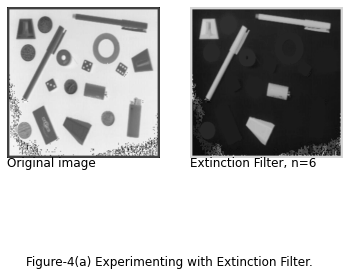

In [31]:
# Negating image
neg_img = get_negative_img(img_org)

# Applying extinction filter with n = 6
n = 6 
img_filtered = apply_extinction_filter(neg_img, get_eight_connectivity(), n)

#Displaying the orignal and filtered image
fig = plt.figure()

plt.subplot(1,2,1)
plt.imshow(img_org, cmap='gray')
plt.axis('off')
plt.title("Original image", y=-0.1, loc="left")

plt.subplot(1,2,2)
plt.imshow(img_filtered, cmap='gray')
plt.axis('off')
plt.title( "Extinction Filter, n=%d" %n, y=-0.1, loc="left")

plt.suptitle("Figure-4(a) Experimenting with Extinction Filter.",y=-0.1)

##### Area open filter

Text(0.5, -0.1, 'Figure-4(b) Experimenting with Area Open Filter.')

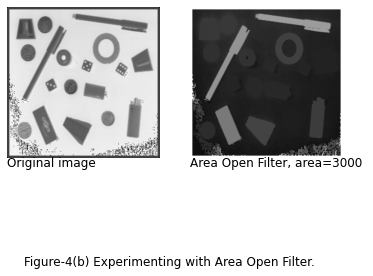

In [32]:
img_neg = get_negative_img(img_org)

area = 3000
img_filtered = apply_area_open_filter(img_neg, get_four_connectivity(),area)


#Displaying the orignal and filtered image
fig = plt.figure()

plt.subplot(1,2,1)
plt.imshow(img_org, cmap='gray')
plt.axis('off')
plt.title("Original image", y=-0.1, loc="left")

plt.subplot(1,2,2)
plt.imshow(img_filtered, cmap='gray')
plt.axis('off')
plt.title( "Area Open Filter, area=%d " %area, y=-0.1, loc="left")

plt.suptitle("Figure-4(b) Experimenting with Area Open Filter.",y=-0.1)

##### Signature analysis

mxt stats: shape (11, 10177)
levels: 33 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32] 
[146304 146033 145964 145888 145803 145698 145581 145434 145290 145085
 144777 144392 143934 143341 142790 142381 141875 141090 139062 135021
 129679 122910 115384 104690  96342  85658  73780  69281  63427  58961
  51781  47840  44760]


'\nfor ind in range(len(levels)-1):\n    # ind = 2\n    # Selecting the second peak of the gradient\n    index = np.argsort(gradient)[::-1][ind]\n    #reconstructing the node corresponding to the peak (largest area)\n    area1 = signature[index]\n    node1 = np.where(mxt.node_array[3,:] == area1)[0][0]\n    cc1 = mxt.recConnectedComponent(node1)\n    #reconstructing the node corresponding to the peak (smaller area)\n    area2 = signature[index + 1]\n    node2 = np.where(mxt.node_array[3,:] == area2)[0][0]\n    cc2 = mxt.recConnectedComponent(node2)\n\n    show_image(cc1, "big")\n    show_image(cc2, "small")'

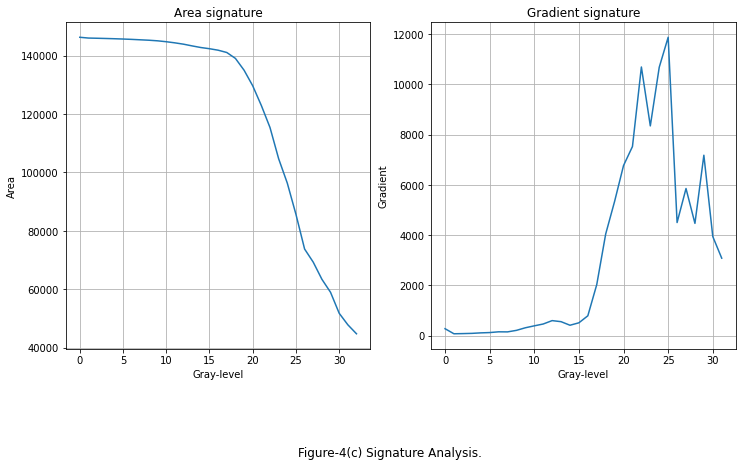

In [33]:
#show_image(img_org, "Orginal")
img_neg = get_negative_img(img_org)


# Building the max-tree
mxt = siamxt.MaxTreeAlpha(img_neg, get_eight_connectivity())
print("mxt stats: shape %s" % (str(mxt.node_array.shape)))
#Hand-picked regional maxima. Copied from lecture. No idea what these means
x, y = 83,90
# Node corresponding to a regional maximum. NO idea why this necessary
node = mxt.node_index[x, y]
# Extracting area attribute from NA
area = mxt.node_array[3,:]

# Area signature computation
levels, signature =  mxt.getSignature(area, node)
print("levels: %d %s " % (len(levels), levels))
print(signature)
#Gradient of the area signature
gradient = signature[0:-1] - signature[1:]
# Display area signature
fig = plt.figure(figsize = (12,6))
plt.subplot(121)
plt.plot(levels, signature)
plt.grid()
plt.xlabel("Gray-level")
plt.ylabel("Area")
plt.title("Area signature")
# Display gradient of the area signature
plt.subplot(122)
plt.grid()
plt.plot(levels[0:-1],gradient)
plt.xlabel("Gray-level")
plt.ylabel("Gradient")
plt.title("Gradient signature")

plt.suptitle("Figure-4(c) Signature Analysis.",y=-0.1)
'''
for ind in range(len(levels)-1):
    # ind = 2
    # Selecting the second peak of the gradient
    index = np.argsort(gradient)[::-1][ind]
    #reconstructing the node corresponding to the peak (largest area)
    area1 = signature[index]
    node1 = np.where(mxt.node_array[3,:] == area1)[0][0]
    cc1 = mxt.recConnectedComponent(node1)
    #reconstructing the node corresponding to the peak (smaller area)
    area2 = signature[index + 1]
    node2 = np.where(mxt.node_array[3,:] == area2)[0][0]
    cc2 = mxt.recConnectedComponent(node2)

    show_image(cc1, "big")
    show_image(cc2, "small")'''



#### Final Solutions 

Final solution using Approach-1 and Approach-2 are as follow.

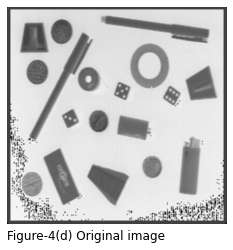

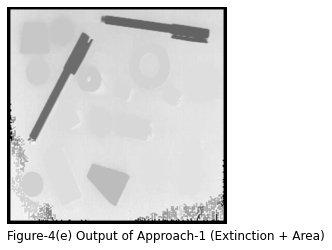

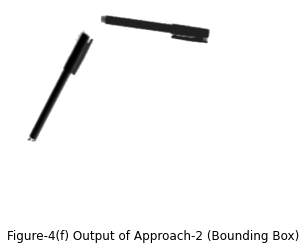

In [34]:
show_image(img_org, "Figure-4(d) Original image")


## Approach-1
# Negating the original image before applying filter
neg_img = get_negative_img(img_org)

# Applying extinction filter to keep the top 6 extrema
img_filtered = apply_extinction_filter(neg_img, get_eight_connectivity(), 6)

# Applying area open filter to remove the extra objects
img_filtered = apply_area_open_filter(img_filtered, get_eight_connectivity(), area=3000)

# Re-Negating the filtered image
img_pos = get_negative_img(img_filtered)
# Showing the output
show_image(img_pos, "Figure-4(e) Output of Approach-1 (Extinction + Area)")



## Approach-2
img_neg = get_negative_img(img_org)

# Setting up bounding box parameters
Wmin = 70
Hmin = 40
Wmax = 190
Hmax = 200
rr_min = 0.0
rr_max = 0.4

# Applying bounding box filter
img_filtered = apply_bounding_box_filter(img_neg, Wmin, Hmin, Wmax, Hmax, rr_min, rr_max)

# Re-Negating the filtered image
img_pos = get_negative_img(img_filtered)

# Showing the output
show_image(img_pos, "Figure-4(f) Output of Approach-2 (Bounding Box)")